# SLE case-control associations in Perez et al dataset

In [1]:
import pandas as pd
import numpy as np
import cna, pp, pickle, os
import matplotlib.pyplot as plt
import scanpy as sc
np.random.seed(0)
res_folder = "/data/srlab/lrumker/MCSC_Project/cna-prs/results/SLE_casecontrol/"
src_folder = "/data/srlab/lrumker/datasets/perez_sle/pheno/"
fig_dir = "/data/srlab/lrumker/MCSC_Project/cna-prs/figs/"

# From Okabe & Ito, "colorblind-friendly" palette 
from matplotlib.colors import LinearSegmentedColormap
color_dict = {'orange': '#E69F00', 'skyblue': '#56B4E9', 'green': '#009E73', 
              'yellow': '#F0E442', 'purple': '#CC79A7', 'oceanblue': '#0072B2', 
              'vermillion': '#E63d00'} # O&I use '#D55E00'

# Subscript in text mode not math mode (avoids italics)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [2]:
curr_dir = os.getcwd()
os.chdir('/data/srlab/lrumker/MCSC_Project/cna-qtl/GeNA-applied/notebooks/')
from figure_functions import *
os.chdir(curr_dir)

## Test associations

In [3]:
cohort = "EUR"
for celltype in ["T", "Myeloid", "NK", "B"]:
    print(celltype)
    d = cna.read(src_folder+cohort+"_"+celltype+"_1K1Kindependent.h5ad")

    ifn_genes = ['ISG15', 'IFI44L'] 
    i_ifn_genes = [i for i in np.arange(d.var.shape[0]) if d.var.index[i] in ifn_genes]
    ifn_percell = d.X[:,i_ifn_genes].sum(axis=1)
    d.obs['IFN'] = ifn_percell
    d.obs_to_sample(['IFN'], aggregate = np.mean)

    covs = ['age', 'sex_M']
    res = cna.tl.association(d, d.samplem['sle'], 
                             batches=d.samplem['batch'], covs = d.samplem[covs], Nnull=5000, seed = 0)

    vargene_cors = []
    for i_gene in np.arange(d.var.shape[0]):
        vargene_cors.append(np.corrcoef(d.X[res.kept, i_gene], res.ncorrs)[0,1])
    res.vargene_cors=pd.DataFrame({'gene':d.var.index, 'cor': vargene_cors})
    res.UMAP1 = d.obsm['X_umap'][res.kept,0]
    res.UMAP2 = d.obsm['X_umap'][res.kept,1]
    res.IFN = d.obs.IFN[res.kept]

    pickle.dump(res, open(res_folder+"Perez_Obs_SLE_"+celltype+".p", 'wb'))
    covs = ['age', 'sex_M', 'IFN']
    res = cna.tl.association(d, d.samplem['sle'], batches=d.samplem['batch'], covs = d.samplem[covs], seed = 0)
    pickle.dump(res, open(res_folder + "Perez_Obs_SLE_"+celltype+"_cntrl_IFN.p", 'wb'))

T


/data/srlab/lrumker/MCSC_Project/cna/src/cna/tools/_association.py:61: UserWarning: data supported use of 8 NAM PCs, which is the maximum considered. Consider allowing more PCs by using the "ks" argument.
  warnings.warn(('data supported use of {} NAM PCs, which is the maximum considered. '+\


Myeloid


/data/srlab/lrumker/MCSC_Project/cna/src/cna/tools/_association.py:79: UserWarning: global association p-value attained minimal possible value. Consider increasing Nnull
  warnings.warn('global association p-value attained minimal possible value. '+\


NK
B


In [4]:
# Top associated genes in each major cell type
for celltype in ['Myeloid','NK', 'B', 'T']:
    res = pickle.load(open(res_folder+"Perez_Obs_SLE_"+celltype+".p", 'rb'))
    print(res.vargene_cors.iloc[np.argsort(-res.vargene_cors['cor'].values),:].head(10))

          gene       cor
2        ISG15  0.627068
41        IFI6  0.625250
965       LY6E  0.540479
1121    IFITM3  0.525468
78      IFI44L  0.524022
1544      MT2A  0.409049
1957  APOBEC3A  0.374935
79       IFI44  0.365498
1983       MX1  0.362983
1353    EPSTI1  0.362708
        gene       cor
89    IFI44L  0.389858
4      ISG15  0.352204
40      IFI6  0.305861
1991     MX1  0.293429
952     LY6E  0.293427
1956  LGALS1  0.239315
1333    OAS1  0.224153
90     IFI44  0.222127
1611    XAF1  0.215735
1130    IRF7  0.206121
        gene       cor
67    IFI44L  0.353223
1453     FOS  0.269907
1467   TCL1A  0.254710
1267    CD69  0.243950
52       JUN  0.234025
2      ISG15  0.232471
1628    XAF1  0.226610
1970     MX1  0.223740
609    DUSP1  0.207184
24      IFI6  0.202687
        gene       cor
139   S100A4  0.411880
1637    CCL5  0.365909
1520    IL32  0.349453
559     GZMA  0.311892
1864    NKG7  0.297354
1      ISG15  0.289568
81    IFI44L  0.288048
1072    SRGN  0.284701
1738    CST7

## Bootstrapped p-values for phenotype correlations to interferon signaling

In [5]:
def perm_p_ifn_cor(celltype, nreps = 1000):

    res = pickle.load(open(res_folder+"Perez_Obs_SLE_"+celltype+".p", 'rb'))
    d = cna.read("/data/srlab/lrumker/datasets/perez_sle/pheno/EUR_"+celltype+"_1K1Kindependent.h5ad")
    IFN = d.obs.loc[res.kept, ['id']]
    IFN['IFN'] = res.IFN
    ncorrs_df = d.obs.loc[res.kept, ['id']]
    ncorrs_df['ncorrs'] = res.ncorrs
    
    ncorrs_df['cellid'] = np.repeat('', ncorrs_df.shape[0])
    for donor in ncorrs_df.id.value_counts().index:
        ncorrs_df.loc[ncorrs_df.id==donor,'cellid'] = [donor+"_"+str(i) for i in np.arange(np.sum(ncorrs_df.id==donor))]
    for donor in IFN.id.value_counts().index:
        IFN.loc[IFN.id==donor,'cellid'] = [donor+"_"+str(i) for i in np.arange(np.sum(IFN.id==donor))]
    ncorrs_df.set_index('cellid', inplace = True, drop = True)
    IFN.set_index('cellid', inplace = True, drop = True)
    
    np.random.seed(0)
    corr_magnitude = []
    for i in np.arange(nreps):
        donors = np.random.choice(d.samplem.index, d.N)
        bootstrap_ncorrs = np.concatenate([ncorrs_df.loc[[donor+"_"+str(i) for i in np.arange(np.sum(ncorrs_df.id==donor))],'ncorrs'].values \
                    for donor in donors])
        bootstrap_ifn = np.concatenate([IFN.loc[[donor+"_"+str(i) for i in np.arange(np.sum(IFN.id==donor))],'IFN'].values \
                    for donor in donors])
        corr_magnitude.extend([np.abs(np.corrcoef(bootstrap_ifn,bootstrap_ncorrs)[0,1])])

    # P-value
    return(np.sum(np.array(corr_magnitude)<=0)/len(corr_magnitude))

In [6]:
perm_p_ifn_cor("B")

0.0

In [7]:
perm_p_ifn_cor("NK")

0.0

In [8]:
perm_p_ifn_cor("T")

0.0

In [9]:
perm_p_ifn_cor("Myeloid")

0.0

## Supplementary figure

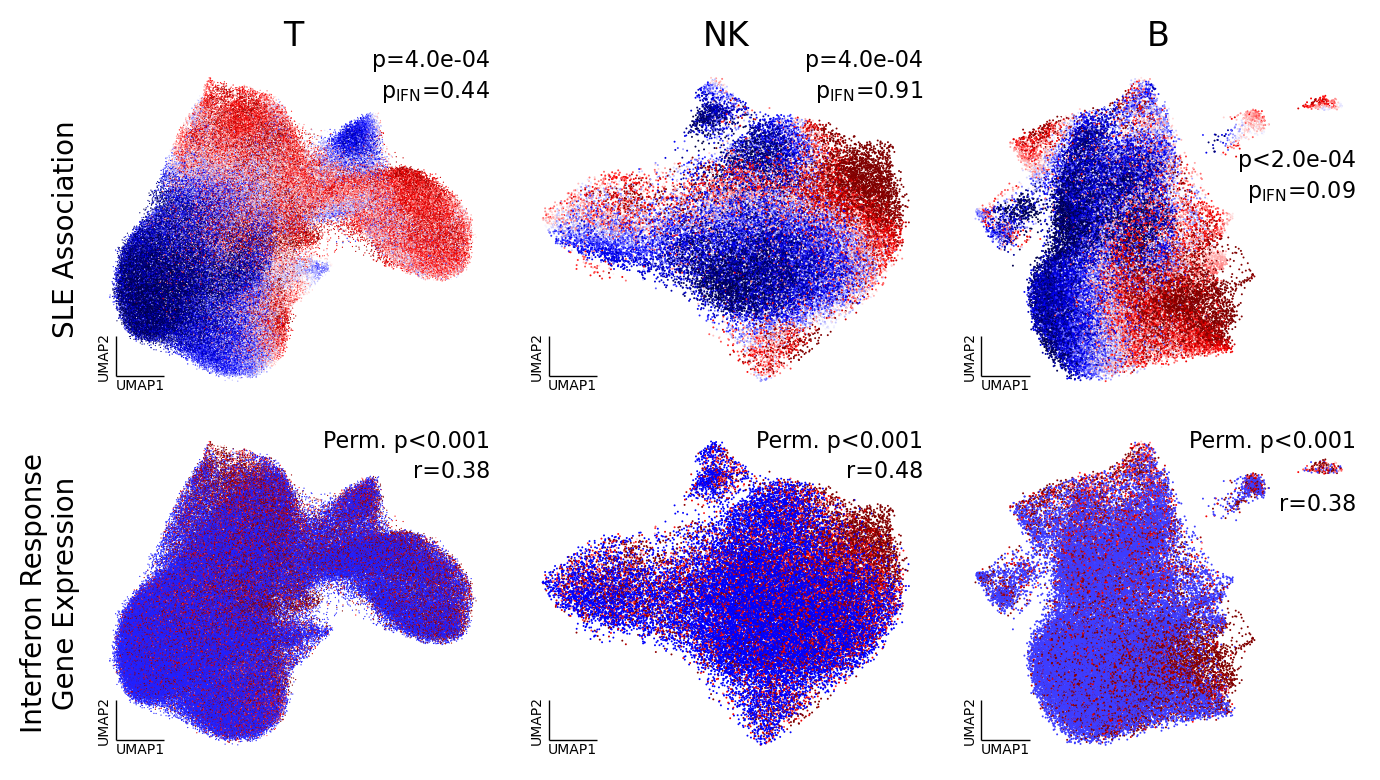

In [10]:
celltypes = ["T", "NK", "B", "T", "NK", "B"]
fig, axs = plt.subplots(2, 3, figsize = (7,4), dpi = 200)
for i, ax in enumerate(axs.reshape(-1)):
    if i in [0,3]: pp.umapprops['s']=0.2
    else: pp.umapprops['s']=0.5
    if i<3:
        res = pickle.load(open(res_folder+"Perez_Obs_SLE_"+celltypes[i]+".p", 'rb'))
        res_ifn = pickle.load(open(res_folder+"Perez_Obs_SLE_"+celltypes[i]+"_cntrl_IFN.p", 'rb'))
        pp.scatter_random(res.UMAP1, res.UMAP2, c = res.ncorrs, cmap = "seismic", ax = ax,
                          vmin=-3, vmax =-1)
        
        if celltypes[i] == "B": 
            ax.text(0.99, 0.74, "p<"+'{:.1e}'.format(res.p),  # minimum p-value attained
                                        ha='right', va='top', transform=ax.transAxes, fontsize=8)
            ax.text(.99, 0.65, "p$_{IFN}$="+str(np.around(res_ifn.p,2)), ha='right', va='top', 
                    transform=ax.transAxes, fontsize=8)
        elif celltypes[i] == "Myeloid": 
            ax.text(0.99, 0.9, "p<"+'{:.1e}'.format(res.p),  # minimum p-value attained
                                        ha='right', va='top', transform=ax.transAxes, fontsize=8)
            ax.text(.99, 0.81, "p$_{IFN}$="+str(np.around(res_ifn.p,2)), ha='right', va='top', 
                    transform=ax.transAxes, fontsize=8)
        else: 
            ax.text(.99, 1.04, "p="+'{:.1e}'.format(res.p), 
                      ha='right', va='top', transform=ax.transAxes, fontsize=8) 
            ax.text(.99, 0.95, "p$_{IFN}$="+str(np.around(res_ifn.p,2)), ha='right', va='top', 
                    transform=ax.transAxes, fontsize=8) 
        ax.set_title(celltypes[i]+": SLE")
        
    if i>2:
        res = pickle.load(open(res_folder+"Perez_Obs_SLE_"+celltypes[i]+".p", 'rb'))
        pp.scatter_random(res.UMAP1, res.UMAP2, c = res.IFN, cmap = "seismic", ax = ax,
                          vmin=-3, vmax =0)
        rval = np.corrcoef(res.IFN, res.ncorrs)[0,1]
        ax.text(.99, 0.99, "Perm. p<0.001", ha='right', va='top', transform=ax.transAxes, fontsize=8)
        if celltypes[i]=="B":
            ax.text(.99, 0.8, "r="+str(np.around(rval,2)), ha='right', va='top', transform=ax.transAxes, fontsize=8) 
        else:
            ax.text(.99, 0.9, "r="+str(np.around(rval,2)), ha='right', va='top', transform=ax.transAxes, fontsize=8) 
    
    # To remove axes but keep axis titles
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_xticks([])
    for key, spine in ax.spines.items():
        spine.set_visible(False)
    add_umap_axes(ax, umap_axis_length = 0.12, umap_axis_offset = 0.06, 
              axis_lw = 0.5, umap_text_size = 5)
        
    if i<3: ax.set_title(celltypes[i])
    if i==0: ax.set_ylabel("SLE Association")  
    if i==3: ax.set_ylabel("Interferon Response\nGene Expression")  

plt.tight_layout()
plt.savefig(fig_dir+"Perez_SLE.png",transparent=True)
plt.show()